Copyright 2018 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook tries to  predict the discharge ICU using MIMIC-III database (team 9 challenge). It was created in the DATATHON TARRAGONA 2018 (http://www.datathontarragona.com/).

#### Pitcher:

* Daniel Cañueto

#### Team members:

* Xavier Borrat
* Jesús Caballero
* Cecilia Cuzco
* Bruna Corrêa
* Antonio Oscar Gallesio
* Montserrat Rodríguez
* Carme Zambrana





## ICU discharge prediction

Logistic in ICU is an important issue due to the high number of admission requests and the scarce number of available beds. Having an accurate estimator of the time for discharge for the patients admitted would be of huge importance for unit management. The aim of this project is to create this prognosis estimator of the time for discharge. We will focus on patients with sepsis that spent at least 3 days in the ICU and were discharged alive.

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
import tensorflow as tf

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

import seaborn as sns

In [0]:
auth.authenticate_user()

In [0]:
project_id='datathon-tarragona-2018'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

Let's define a few methods to wrap BigQuery operations, so that we don't have to write the configurations again and again.

In [0]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

## Data collection


We will focus on patients with:

sepsis that  and .

*  Sepsis (using the angus score)
*  Spent at least 3 days in the ICU
* They were discharged alive


Note: for simplicity we will use each ICU stay as a new patient although that will introduce possible correlation. A better criteria should be used.




In [0]:
df = run_query('''
SELECT out.ICUSTAY_ID, out.intime, out.outtime, ad.deathtime
  FROM (`physionet-data.mimiciii_clinical.icustays` as out  
  LEFT JOIN `physionet-data.mimiciii_derived.angus_sepsis` as an ON an.hadm_id = out.hadm_id)
  LEFT JOIN `physionet-data.mimiciii_clinical.admissions` as ad ON ad.hadm_id = out.hadm_id
  WHERE an.angus = 1
        AND out.los > 3.0
        AND (ad.deathtime > out.outtime OR ad.deathtime IS NULL)''')

In [0]:
dict_ns = { 
'ICU stays' : run_query('''
SELECT ICUSTAY_ID
FROM `physionet-data.mimiciii_clinical.icustays`
''').shape[0],
 'ICU stays related with Sepsis' : 
 run_query('''
SELECT out.ICUSTAY_ID
  FROM `physionet-data.mimiciii_clinical.icustays` as out
  LEFT JOIN `physionet-data.mimiciii_derived.angus_sepsis` as an ON an.hadm_id = out.hadm_id
  WHERE an.angus = 1''').shape[0],
 'ICU stays related with Sepsis that stayed more than 3 days' :
run_query('''
SELECT out.ICUSTAY_ID
  FROM `physionet-data.mimiciii_clinical.icustays` as out
  LEFT JOIN `physionet-data.mimiciii_derived.angus_sepsis` as an ON an.hadm_id = out.hadm_id
  WHERE an.angus = 1 
        AND out.los > 3.0''').shape[0],
'ICU stays related with Sepsis that stayed more than 3 days and were discharged alive' : df.shape[0]
}

dict_ns

{'ICU stays': 61532,
 'ICU stays related with Sepsis': 17420,
 'ICU stays related with Sepsis that stayed more than 3 days': 10240,
 'ICU stays related with Sepsis that stayed more than 3 days and were discharged alive': 8568}

In [0]:
dfSeveralICUStays = run_query('''
WITH dataset as (
SELECT out.ICUSTAY_ID, out.intime, out.outtime, ad.deathtime, out.hadm_id
  FROM (`physionet-data.mimiciii_clinical.icustays` as out  
  LEFT JOIN `physionet-data.mimiciii_derived.angus_sepsis` as an ON an.hadm_id = out.hadm_id)
  LEFT JOIN `physionet-data.mimiciii_clinical.admissions` as ad ON ad.hadm_id = out.hadm_id
  WHERE an.angus = 1
        AND out.los > 3.0
        AND (ad.deathtime > out.outtime OR ad.deathtime IS NULL))
  SELECT COUNT(ICUSTAY_ID) as numberStaysPerHospAdmission
  FROM dataset
  GROUP BY (hadm_id)
  ''')

print(dfSeveralICUStays[dfSeveralICUStays['numberStaysPerHospAdmission'] > 1].shape[0] )

540


### LETS GET THE VARIABLES

SOFA

In [0]:
dfSofa = run_query('''
SELECT out.ICUSTAY_ID, s.sofa, COALESCE(s.respiration,0)+COALESCE(s.cardiovascular,0)+COALESCE(s.cns,0) as msofa
  FROM (`physionet-data.mimiciii_clinical.icustays` as out  
  LEFT JOIN `physionet-data.mimiciii_derived.angus_sepsis` as an ON an.hadm_id = out.hadm_id)
  LEFT JOIN `physionet-data.mimiciii_clinical.admissions` as ad ON ad.hadm_id = out.hadm_id
  LEFT JOIN `physionet-data.mimiciii_derived.sofa` as s ON s.ICUSTAY_ID = out.ICUSTAY_ID
  WHERE an.angus = 1
        AND out.los > 3.0
        AND (ad.deathtime > out.outtime OR ad.deathtime IS NULL)'''
              
              )

print dfSofa.shape
dfSofa.head()

(8568, 3)


,ICUSTAY_ID,sofa,msofa
0,225122,0,0
1,283375,0,0
2,208941,0,0
3,288262,0,0
4,242687,0,0


LACTATE

--> diferencia al ingreso y al tercer día

In [0]:
dfLactateAdICU = run_query('''
WITH lactate as (SELECT out.ICUSTAY_ID, charEV.CHARTTIME, charEV.VALUENUM, out.INTIME
  FROM (`physionet-data.mimiciii_clinical.admissions` as ad 
  LEFT JOIN `physionet-data.mimiciii_clinical.icustays` as out ON ad.HADM_ID=out.HADM_ID)
  LEFT JOIN `physionet-data.mimiciii_derived.angus_sepsis` as an ON an.hadm_id = ad.hadm_id
  LEFT JOIN `physionet-data.mimiciii_clinical.labevents` as charEV ON charEV.HADM_ID = out.HADM_ID
  WHERE an.angus = 1
        AND out.los > 3.0
        AND (ad.deathtime > out.outtime OR ad.deathtime IS NULL)
        AND charEV.ITEMID = 50813
  )
SELECT lactate.ICUSTAY_ID, lactate.VALUENUM as lactateleveladICU
  FROM 
  (SELECT lactate.ICUSTAY_ID, MIN(lactate.CHARTTIME) as HOURCHARTTIMEFROMADMISSIONICU
  FROM lactate
  WHERE lactate.CHARTTIME BETWEEN lactate.intime AND DATETIME_ADD(lactate.intime,  INTERVAL 24 hour)
  GROUP BY lactate.ICUSTAY_ID) as tmp, lactate
  WHERE tmp.ICUSTAY_ID = lactate.ICUSTAY_ID AND tmp.HOURCHARTTIMEFROMADMISSIONICU = lactate.CHARTTIME
  ORDER BY lactate.ICUSTAY_ID
''')
 
print dfLactateAdICU.shape
dfLactateAdICU.head()

(5414, 2)


,ICUSTAY_ID,lactateleveladICU
0,200003,5.1
1,200030,4.0
2,200063,4.9
3,200065,10.1
4,200087,2.2


In [0]:
dfLactate72AdICU = run_query('''
WITH lactate as (SELECT out.ICUSTAY_ID, charEV.CHARTTIME, charEV.VALUENUM, out.INTIME
  FROM (`physionet-data.mimiciii_clinical.admissions` as ad 
  LEFT JOIN `physionet-data.mimiciii_clinical.icustays` as out ON ad.HADM_ID=out.HADM_ID)
  LEFT JOIN `physionet-data.mimiciii_derived.angus_sepsis` as an ON an.hadm_id = ad.hadm_id
  LEFT JOIN `physionet-data.mimiciii_clinical.labevents` as charEV ON charEV.HADM_ID = out.HADM_ID
  WHERE an.angus = 1
        AND out.los > 3.0
        AND (ad.deathtime > out.outtime OR ad.deathtime IS NULL)
        AND charEV.ITEMID = 50813
  )SELECT lactate.ICUSTAY_ID, lactate.VALUENUM as lactatelevel72adICU
  FROM 
  (SELECT lactate.ICUSTAY_ID, MIN(lactate.CHARTTIME) as HOURCHARTTIMEFROMADMISSIONICU
  FROM lactate
  WHERE lactate.CHARTTIME BETWEEN DATETIME_ADD(lactate.intime,  INTERVAL 72 hour) AND DATETIME_ADD(lactate.intime,  INTERVAL 96 hour)
  GROUP BY lactate.ICUSTAY_ID) as tmp, lactate
  WHERE tmp.ICUSTAY_ID = lactate.ICUSTAY_ID AND tmp.HOURCHARTTIMEFROMADMISSIONICU = lactate.CHARTTIME
  ORDER BY lactate.ICUSTAY_ID, lactate.CHARTTIME
''')
 
print dfLactate72AdICU.shape
dfLactate72AdICU.head()

(2059, 2)


,ICUSTAY_ID,lactatelevel72adICU
0,200003,1.0
1,200030,1.1
2,200063,1.3
3,200065,3.1
4,200077,2.0


In [0]:
dfLactate72AdICU2 = run_query('''
WITH lactate as (SELECT out.ICUSTAY_ID, charEV.CHARTTIME, charEV.VALUENUM, out.INTIME
  FROM (`physionet-data.mimiciii_clinical.admissions` as ad 
  LEFT JOIN `physionet-data.mimiciii_clinical.icustays` as out ON ad.HADM_ID=out.HADM_ID)
  LEFT JOIN `physionet-data.mimiciii_derived.angus_sepsis` as an ON an.hadm_id = ad.hadm_id
  LEFT JOIN `physionet-data.mimiciii_clinical.labevents` as charEV ON charEV.HADM_ID = out.HADM_ID
  WHERE an.angus = 1
        AND out.los > 3.0
        AND (ad.deathtime > out.outtime OR ad.deathtime IS NULL)
        AND charEV.ITEMID = 50813
  )
  
  SELECT lactate.ICUSTAY_ID, MAX(lactate.VALUENUM) as maxLactetate72ICUad
  FROM lactate
  WHERE lactate.CHARTTIME BETWEEN DATETIME_ADD(lactate.intime,  INTERVAL 72 hour) AND DATETIME_ADD(lactate.intime,  INTERVAL 96 hour)
  GROUP BY lactate.ICUSTAY_ID
''')
 
print dfLactate72AdICU2.shape
dfLactate72AdICU2.head()

(2059, 2)


,ICUSTAY_ID,maxLactetate72ICUad
0,255154,NaN
1,207278,2.0
2,251035,2.0
3,267207,2.0
4,284798,2.0


In [0]:
dfLactate = dfLactateAdICU.merge(dfLactate72AdICU, how='inner', on='ICUSTAY_ID')
dfLactate = dfLactate.merge(dfLactate72AdICU2, how='inner', on='ICUSTAY_ID')
dfLactate.insert(1, 'DiffLactateLevel', dfLactate['lactatelevel72adICU'] - dfLactate['lactateleveladICU'])
print dfLactate.shape
dfLactate.head()

(1652, 5)


,ICUSTAY_ID,DiffLactateLevel,lactateleveladICU,lactatelevel72adICU,maxLactetate72ICUad
0,200003,-4.1,5.1,1.0,1.0
1,200030,-2.9,4.0,1.1,1.1
2,200063,-3.6,4.9,1.3,1.3
3,200065,-7.0,10.1,3.1,4.2
4,200140,-0.5,1.7,1.2,1.2


MECHANICAL VENTILATION

--> 72h

In [0]:
dfVentilation72adICU = run_query('''
WITH ventilation as (SELECT out.ICUSTAY_ID, charEV.CHARTTIME, charEV.VALUE, out.INTIME
  FROM (`physionet-data.mimiciii_clinical.admissions` as ad 
  LEFT JOIN `physionet-data.mimiciii_clinical.icustays` as out ON ad.HADM_ID=out.HADM_ID)
  LEFT JOIN `physionet-data.mimiciii_derived.angus_sepsis` as an ON an.hadm_id = ad.hadm_id
  LEFT JOIN `physionet-data.mimiciii_clinical.labevents` as charEV ON charEV.HADM_ID = out.HADM_ID
  WHERE an.angus = 1
        AND out.los > 3.0
        AND (ad.deathtime > out.outtime OR ad.deathtime IS NULL)
        AND charEV.ITEMID = 50812
  )SELECT ventilation.ICUSTAY_ID, 
  CASE
    WHEN ventilation.VALUE = 'INTUBATED' THEN 1
    ELSE 0
    END AS ventilationlevel72adICU
  FROM 
  (SELECT ventilation.ICUSTAY_ID, MIN(ventilation.CHARTTIME) as HOURCHARTTIMEFROMADMISSIONICU,  MAX(ventilation.CHARTTIME) as MAXHOURCHARTTIMEFROMADMISSIONICU
  FROM ventilation
  WHERE ventilation.CHARTTIME BETWEEN DATETIME_ADD(ventilation.intime,  INTERVAL 72 hour) AND DATETIME_ADD(ventilation.intime,  INTERVAL 78 hour)
  GROUP BY ventilation.ICUSTAY_ID) as tmp, ventilation
  WHERE tmp.ICUSTAY_ID = ventilation.ICUSTAY_ID AND tmp.HOURCHARTTIMEFROMADMISSIONICU = ventilation.CHARTTIME
''')

print dfVentilation72adICU.shape
dfVentilation72adICU.head()

(946, 2)


,ICUSTAY_ID,ventilationlevel72adICU
0,217675,0
1,229896,0
2,225177,0
3,206077,0
4,209656,0


MORE VARIABLES

* Age at ICU admission time
* Number of days between Hospital admission and ICU admission
* If  the admission was for Emergency



In [0]:
dfNewVariables = run_query('''
SELECT uci.ICUSTAY_ID,  uci.admission_age, DATETIME_DIFF(uci.intime,hosp.ADMITTIME,DAY) as d_pre_ingres,
    CASE
    WHEN uci.admission_type = 'EMERGENCY' THEN 1
    ELSE 0
    END AS ad_type
FROM `physionet-data.mimiciii_derived.icustay_detail` as uci
INNER JOIN  `physionet-data.mimiciii_clinical.admissions` AS hosp ON hosp.hadm_id=uci.hadm_id
WHERE uci.admission_type <> 'NEWBORN'
      AND uci.admission_age > 18
  ''')

print dfNewVariables.shape
dfNewVariables.head()

(52798, 4)


,ICUSTAY_ID,admission_age,d_pre_ingres,ad_type
0,253318,19,0,1
1,265859,19,0,1
2,275243,19,0,1
3,270849,19,0,1
4,299760,19,0,1


In [0]:
new_age = np.where(dfNewVariables['admission_age'].values >= 300, 90, dfNewVariables['admission_age'].values)
dfNewVariables.insert(1, 'ad_age', new_age)

### Target Variable



*   Real ICU stay from ICU in time to callout time

In [0]:
dfTargetValue = run_query('''
WITH cout as (SELECT out.ICUSTAY_ID, co.createtime, out.intime
  FROM (`physionet-data.mimiciii_clinical.icustays` as out  
  LEFT JOIN `physionet-data.mimiciii_derived.angus_sepsis` as an ON an.hadm_id = out.hadm_id)
  LEFT JOIN `physionet-data.mimiciii_clinical.admissions` as ad ON ad.hadm_id = out.hadm_id
  LEFT JOIN `physionet-data.mimiciii_clinical.callout` as co ON co.hadm_id = out.hadm_id
  WHERE an.angus = 1
        AND out.los > 3.0
        AND (ad.deathtime > out.outtime OR ad.deathtime IS NULL)
        AND co.createtime BETWEEN out.intime and out.outtime
  )
  SELECT ICUSTAY_ID, MIN(DATETIME_DIFF(CREATETIME, intime, DAY)) as days_in_ICU
  FROM cout
  GROUP BY ICUSTAY_ID''')



print dfTargetValue.shape
dfTargetValue.head()

(5089, 2)


,ICUSTAY_ID,days_in_ICU
0,289487,0
1,251729,0
2,281453,0
3,213339,0
4,288590,0


### Baseline Dataset


* SOFA score at ICU admission time
* Lactate difference between ICU admission time and after 72h
* Maximum value lactate after 72h ICU admission
* Mecanical ventilation after 72h  ICU admission
* Age at ICU admission time
* Number of days between Hospital admission and ICU admission
* If  the admission was for Emergency



In [0]:
dfBaseline = pd.merge(dfSofa[['ICUSTAY_ID', 'msofa']], dfLactate[['ICUSTAY_ID', 'DiffLactateLevel', 'maxLactetate72ICUad']], on='ICUSTAY_ID')
dfBaseline = pd.merge(dfBaseline, dfVentilation72adICU, on='ICUSTAY_ID')
dfBaseline = pd.merge(dfBaseline, dfNewVariables, on='ICUSTAY_ID')
dfBaseline = pd.merge(dfBaseline, dfTargetValue, on='ICUSTAY_ID')


print dfBaseline.shape
dfBaseline.head()

(125, 10)


,ICUSTAY_ID,msofa,DiffLactateLevel,maxLactetate72ICUad,ventilationlevel72adICU,ad_age,admission_age,d_pre_ingres,ad_type,days_in_ICU
0,287339,0,0.7,1.8,1,36,36,8,1,11
1,277388,0,-1.5,0.7,1,24,24,0,1,26
2,290135,0,-3.2,1.0,1,19,19,0,1,8
3,248839,0,-0.3,1.0,1,56,56,0,1,17
4,225095,0,-1.5,1.0,1,78,78,0,1,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f559f827550>]],
      dtype=object)

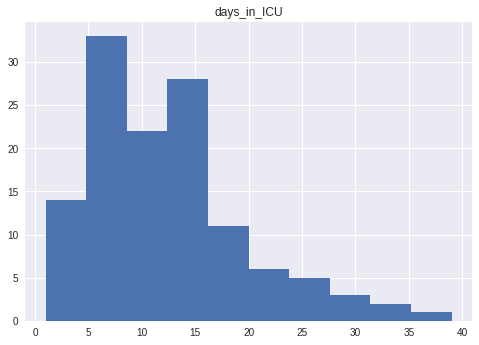

In [0]:
dfBaseline.hist('days_in_ICU')

The patients who stay more than 20 days in the ICU are outlier. We decided to excluded them.

In [0]:
dfBaseline = dfBaseline[dfBaseline['days_in_ICU'] < 20]
dfBaseline.shape

(108, 10)

## Analysis

In [0]:
features = ['msofa', 'DiffLactateLevel', 'ventilationlevel72adICU', 'maxLactetate72ICUad', 'ad_age', 	'd_pre_ingres', 'ad_type']
target = ['days_in_ICU']

### Exploring the dataset

In [0]:
from google.colab import files
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

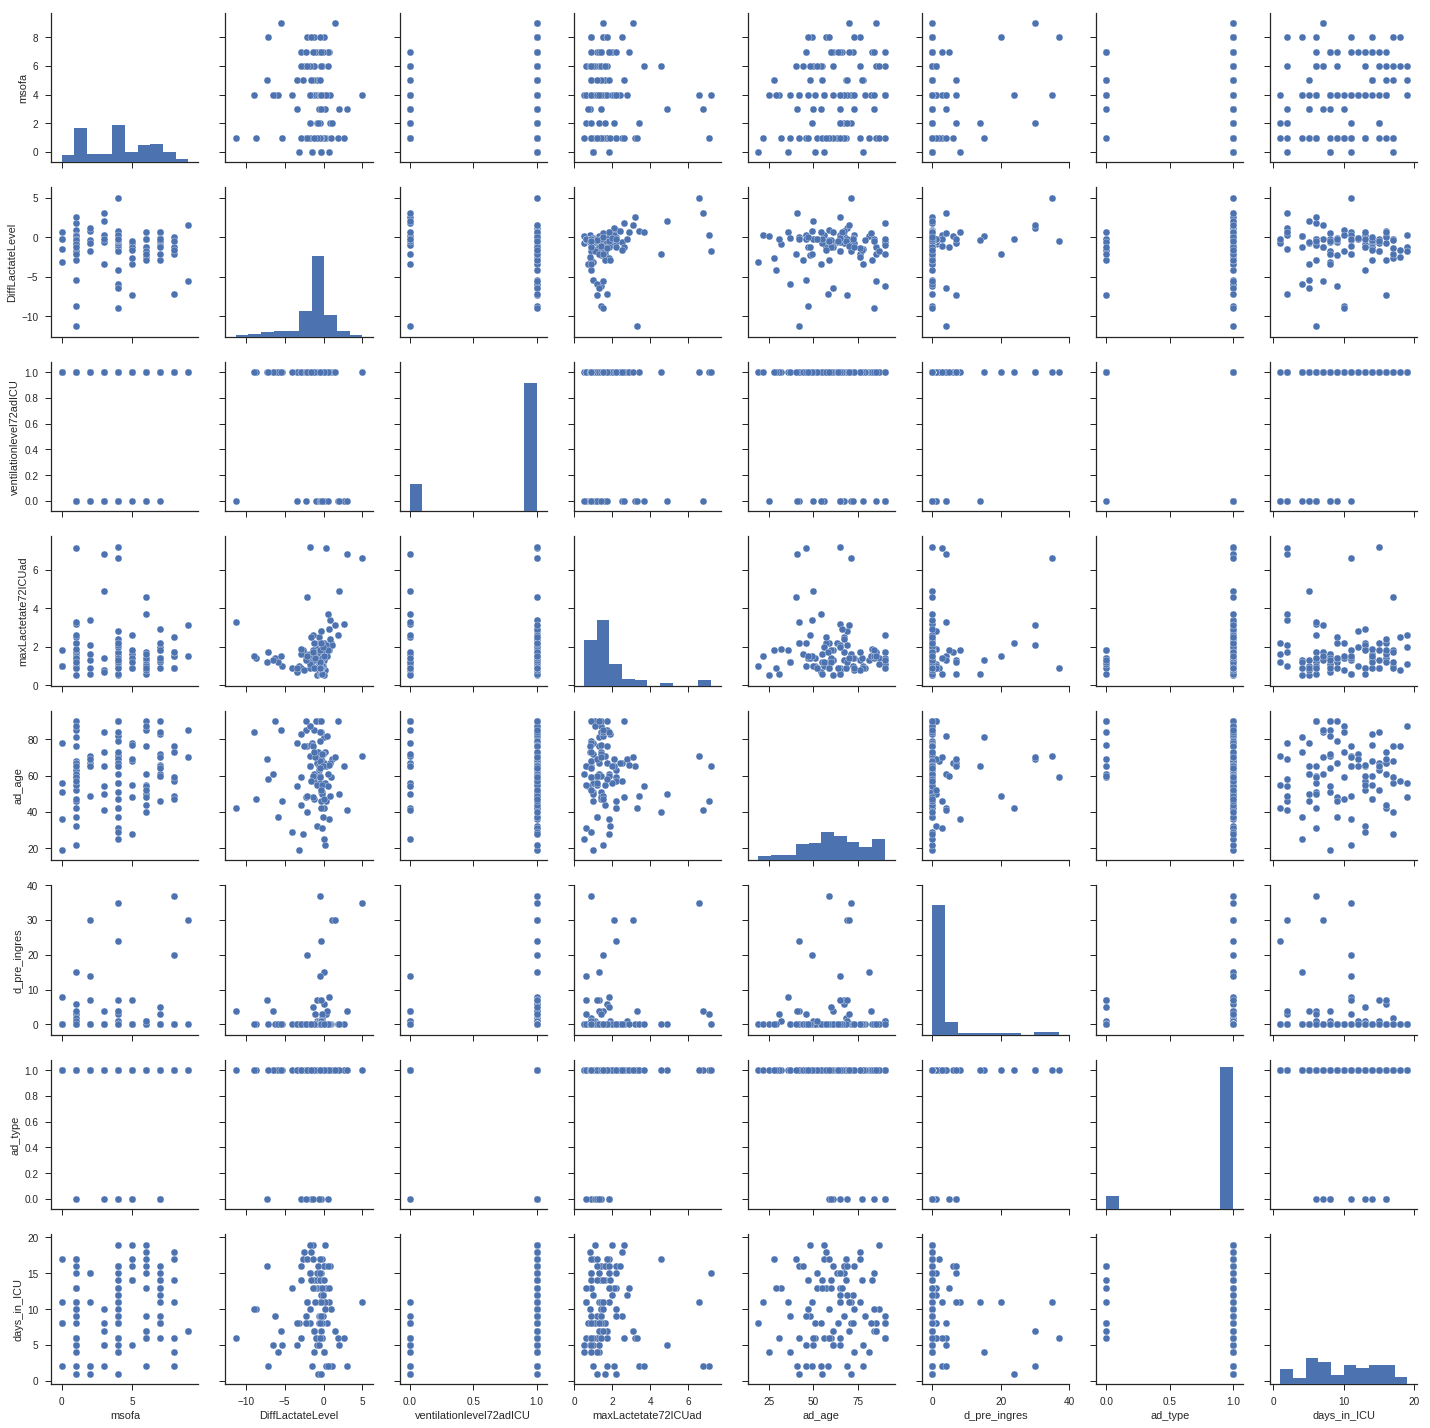

In [0]:
sns.pairplot(dfBaseline[features + target])

plt.savefig("Pariplot.png")
files.download("Pariplot.png") 

### Splitting dataset

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [0]:
X = dfBaseline[features].values
y = dfBaseline[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
df_train = pd.DataFrame(X_train, columns=features)
df_train.insert(0, target[0], y_train)

df_test = pd.DataFrame(X_test, columns=features)
df_test.insert(0, target[0], y_test)

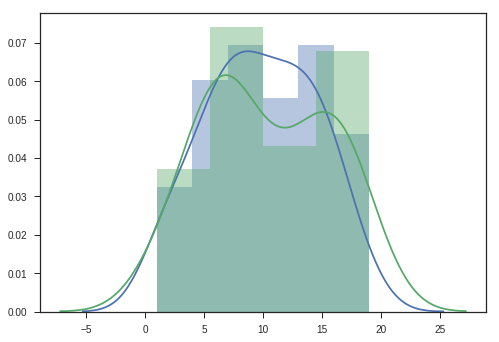

In [0]:
sns.distplot(y_train)
sns.distplot(y_test)

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import metrics

In [0]:
n_estimators_RF =  [5,10,15,20,25,30,35]
max_features_RF = [2,3,4,5,6,7]


tuned_parameters = {"n_estimators": n_estimators_RF, 
                         "max_features": max_features_RF}

In [0]:
clf = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=0), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
clf.fit(X_train, y_train.ravel())

print("Best parameters set found on development set:")
print(clf.best_params_)
print clf.best_score_
print clf.best_estimator_.feature_importances_

y_pred = clf.predict(X_test)

Best parameters set found on development set:
{'max_features': 3, 'n_estimators': 15}
-20.698641975308643
[0.10073045 0.20786635 0.1618814  0.20359981 0.20900382 0.10623891
 0.01067926]


In [0]:
meanValue = np.mean(y_train)
print( meanValue)
y_med = np.full(y_test.shape[0], np.mean(y_train))
print metrics.mean_squared_error(y_test, y_pred)
print metrics.mean_squared_error(y_test, y_med)

9.791666666666666
24.525432098765435
27.571180555555557


In [0]:
df_test = pd.DataFrame(X_test, columns=features)
df_test.insert(0, target[0], y_test)
df_test.insert(0, 'predicted-tree', y_pred)
df_test.insert(0, 'predicted-med', y_med)
df_test.insert(0, 'err-tree',df_test[target[0]] -  df_test['predicted-tree'])

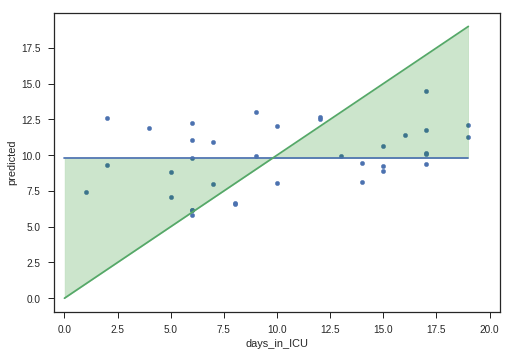

In [0]:
#ax = df_test.plot.scatter(x=target[0], y=features[0], label='True')
ax = df_test.plot.scatter(x=target[0], y='predicted-tree')
x = np.arange(0, 20)
y1 = df_test['predicted-med'].values[0:20]
y2 = np.arange(0,20)
ax.plot(y1)
ax.plot(y2)
plt.xlim((-0.5,20.5))
ax.fill_between(x, y1, y2, alpha=0.2, color='green')
ax.set_ylabel('predicted')
plt.savefig("Results.png")
files.download("Results.png")

In [0]:
featuresNice = np.array(['Diff Lact', 'max Lact 72ICUad', 'Ad Age', 'Sofa',
       'Hosp Stay before ICU', 'Vent Level 72adICU', 'Is emergency'])

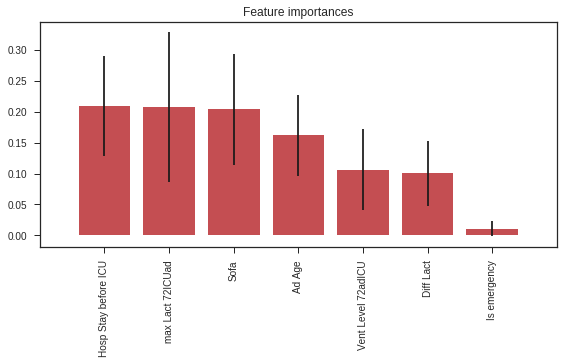

In [0]:
importances = clf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), featuresNice[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.subplots_adjust(bottom=0.5)
plt.savefig("FeatureImportance.png")
files.download("FeatureImportance.png")
plt.tight_layout(rect=(0,0,1,0.95))